In [25]:
import cv2
import os
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from typing import TypedDict, List
from glob import glob

In [2]:
SCALING_FACTOR = 0.03460213

## Utils

In [3]:
def get_rbox_dimensions(bpoints, return_corners=False):
    dis = [p[0]**2 + p[1]**2 for p in bpoints]
    tl_idx = np.argsort(dis)[0]
    tr_idx = (tl_idx + 1) % 4
    br_idx = (tl_idx + 2) % 4
    bl_idx = (tl_idx + 3) % 4
    # return width x height of the rotated bbox
    tl_p = bpoints[tl_idx]
    tr_p = bpoints[tr_idx]
    br_p = bpoints[br_idx]
    bl_p = bpoints[bl_idx]
    dimensions = [np.sqrt((tl_p[0]-tr_p[0])**2 + (tl_p[1]-tr_p[1])**2), np.sqrt((tr_p[0]-br_p[0])**2 + (tr_p[1]-br_p[1])**2)]
    if return_corners:
        corners = [tl_p, tr_p, br_p, bl_p]
        return dimensions, corners
    else:
        return dimensions

def point_to_segment_distance(P, A, B):
    """
    Calculate the distance from point P to the line segment AB.

    Parameters:
        P (array-like): The point [px, py].
        A (array-like): The start point of the segment [ax, ay].
        B (array-like): The end point of the segment [bx, by].

    Returns:
        float: The distance from P to the segment AB.
    """
    # Convert inputs to numpy arrays
    P = np.array(P)
    A = np.array(A)
    B = np.array(B)
    
    # Vector AB and AP
    AB = B - A
    AP = P - A
    
    # Dot product of AB with itself
    AB_AB = np.dot(AB, AB)
    
    # Project AP onto AB (scalar t)
    t = np.dot(AP, AB) / AB_AB if AB_AB != 0 else 0  # Handle division by zero
    
    # Clamp t to the segment range [0, 1]
    if t < 0:
        closest = A  # Closest to A
    elif t > 1:
        closest = B  # Closest to B
    else:
        closest = A + t * AB  # Projection point on the segment
    
    # Distance from P to the closest point on the segment
    dist = np.linalg.norm(P - closest)
    
    return dist

def find_peak_points(contoured_points, A, B, reverse=False, search_range=15):
    """
    Find peak points in a set of contoured points relative to a line segment AB.

    Parameters:
        contoured_points (numpy.ndarray): Array of contour points, shape (N, 2).
        A (list or numpy.ndarray): Point A of the line segment [ax, ay].
        B (list or numpy.ndarray): Point B of the line segment [bx, by].

    Returns:
        numpy.ndarray: Array of peak points.
    """
    distances = np.zeros(len(contoured_points))
    peak_indices = np.zeros(len(contoured_points), dtype=bool)

    # Calculate distances
    for i, p in enumerate(contoured_points):
        if reverse:
            distances[i] = -1*point_to_segment_distance(p, A, B)
        else:
            distances[i] = point_to_segment_distance(p, A, B)

    # Identify peaks
    for i in range(search_range, len(contoured_points) - search_range):
        if min(distances[i-(search_range-1):i+search_range+1]) == distances[i]:
            peak_indices[i-(search_range-1):i+search_range+1] = False
            peak_indices[i] = True

    # Extract peak points
    peak_points = []
    for i, is_peak in enumerate(peak_indices):
        if is_peak:
            peak_cluster_points = [contoured_points[i].tolist()]
            for k in range(max(0,i-3), min(len(peak_indices), i+4)):
                if abs(distances[k] - distances[i]) <= 1:
                    # at K position, exist a point with the same distance as peak point --> get average peak points
                    peak_cluster_points.append(contoured_points[k].tolist())
            peak = np.array(peak_cluster_points).mean(axis=0).astype(np.int32).tolist()
            # print(f"Got total {len(peak_cluster_points)} [{peak_cluster_points}] points of {contoured_points[i]} --> Peak point: {peak}")
            peak_points.append(peak)

    return np.array(peak_points)

In [4]:
def get_best_measured_value(data, method='iqr'):
    """
    Removes outliers and computes the best measured value.
    
    Parameters:
        data (array-like): Array of measured values.
        method (str): Method for outlier detection ('iqr' or 'std').
        
    Returns:
        float: Best measured value after removing outliers (mean of filtered data).
    """
    if method not in ['iqr', 'std']:
        raise ValueError('Invalid method. Choose "iqr" or "std".')

    # Outlier detection and filtering
    if method == 'iqr':
        # IQR-based outlier removal
        Q1 = np.percentile(data, 25)  # First quartile
        Q3 = np.percentile(data, 75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.25 * IQR
        upper_bound = Q3 + 1.25 * IQR
    elif method == 'std':
        # Standard deviation-based outlier removal
        mu = np.mean(data)
        sigma = np.std(data)
        lower_bound = mu - 2 * sigma  # Within 2 standard deviations
        upper_bound = mu + 2 * sigma

    # Filter data within bounds
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]

    # Compute the best measured value (mean of filtered data)
    best_value = np.mean(filtered_data)

    return best_value

In [5]:
def fit_line(xpos, ypos):
    """
    Fits a line using the linear least-squares method.

    Parameters:
        cs (array-like): x-coordinates (column indices).
        rs (array-like): y-coordinates (row indices).

    Returns:
        np.ndarray: Coefficients [a, b, c] of the line equation ax + by + c = 0.
    """
    # Ensure cs and rs are column vectors
    xpos = np.array(xpos).reshape(-1, 1)
    ypos = np.array(ypos).reshape(-1, 1)

    # Construct U matrix
    U = np.hstack((xpos, ypos, np.ones_like(xpos)))

    # Compute eigenvalues and eigenvectors of U'U
    eig_vals, eig_vecs = np.linalg.eig(U.T @ U)

    # Find the eigenvector corresponding to the smallest eigenvalue
    abc = eig_vecs[:, np.argmin(eig_vals)]

    return abc

In [6]:
def point_to_line(P, abc):
    """
    Projects a point P onto a line defined by the coefficients abc.

    Parameters:
        P (array-like): Coordinates of the point [px, py].
        abc (array-like): Coefficients of the line ax + by + c = 0.

    Returns:
        np.ndarray: Projected point on the line [x_proj, y_proj].
    """
    # Extract coefficients
    a, b, c = abc
    px, py = P

    # Determine line segment points A and B based on orientation
    if abs(b) > abs(a):  # Line is closer to vertical
        A = np.array([(b * 0 + c) / -a, 0])
        B = np.array([(b * 1000 + c) / -a, 1000])
    else:  # Line is closer to horizontal
        A = np.array([0, (a * 0 + c) / -b])
        B = np.array([1000, (a * 1000 + c) / -b])

    # Compute vector AB and AP
    AB = B - A
    AP = np.array(P) - A

    # Dot product of AB with itself
    AB_AB = np.dot(AB, AB)

    # Project AP onto AB (scalar t)
    t = np.dot(AP, AB) / AB_AB

    # Compute the projected point
    projected_point = A + t * AB

    return projected_point


## Main program

In [7]:
def measure_screw_dimensions(background_rgb, imfer_rgb, scaling_factor, verbose=False):
    viz_im = cv2.rotate(imfer_rgb, cv2.ROTATE_180)
    measured_values = {"dk": None, "k": None, "D": None, "L": None, "p": None, "dp": None, 
                       "lcrest_points": [], "rcrest_points": [], "ldp_values": [], "rdp_values": []} # return points for detecting defects 
    # Step 1. Convert background & inference images (RGB) to grayscale
    background_g = cv2.cvtColor(background_rgb, cv2.COLOR_RGB2GRAY)
    _, bg_im_bi = cv2.threshold(background_g, 125, 255, cv2.THRESH_BINARY)
    bg_im_bi[:,:600] = 255
    bg_im_bi[:, bg_im_bi.shape[1]-600:] = 255
    bg_im_bi = cv2.rotate(bg_im_bi, cv2.ROTATE_180)
    bg_im_bi = np.uint8(255 - bg_im_bi)

    infer_im_g = cv2.cvtColor(imfer_rgb, cv2.COLOR_RGB2GRAY)    
    _, infer_im_bi = cv2.threshold(infer_im_g, 125, 255, cv2.THRESH_BINARY)
    infer_im_bi[:,:600] = 255
    infer_im_bi[:, infer_im_bi.shape[1]-600:] = 255
    infer_im_bi = cv2.rotate(infer_im_bi, cv2.ROTATE_180)
    infer_im_bi = np.uint8(255 - infer_im_bi)

    # Step 2. Get diff-image that shows only parts of a screw
    diff_im = cv2.subtract(infer_im_bi, bg_im_bi)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # 5x5 rectangular kernel
    open_diff_im = cv2.morphologyEx(diff_im, cv2.MORPH_OPEN, kernel)

    # Step 3. Get connected components for head & body parts
    head_idx = body_idx = None
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(open_diff_im)
    # get first 2 largest connected components excluding background index (0)
    interested_indices = 1 + np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1]  # Skip the background (label 0)
    if centroids[interested_indices[0],1] < centroids[interested_indices[1],1]:
        head_idx = interested_indices[0]
        body_idx = interested_indices[1]
    else:
        head_idx = interested_indices[1]
        body_idx = interested_indices[0]

    # Step 4. Measure head's dimensions
    head_blob = (labels == head_idx).astype(np.uint8) * 255
    contours, _ = cv2.findContours(head_blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the rotated rectangle for the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    rotated_rect = cv2.minAreaRect(largest_contour)
    # Convert the rotated rectangle to box points
    box_points = cv2.boxPoints(rotated_rect)
    box_points = box_points.astype(int)
    # Draw the rectangle on the image
    cv2.drawContours(viz_im, [box_points], -1, (255, 0, 0), 2)
    w, h = get_rbox_dimensions(box_points)
    if verbose:
        print(f"Measured dimensions: dk={w*scaling_factor} mm, k={h*scaling_factor} mm")
    measured_values["k"] = h*scaling_factor
    measured_values["dk"] = w*scaling_factor
    
    # Step 5. Measure body's dimensions
    body_blob = (labels == body_idx).astype(np.uint8) * 255
    ## Step 5.1. L & D (v0 - measured on truncated profile & used Rotated rectangle)
    contours, _ = cv2.findContours(body_blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Get the rotated rectangle for the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    rotated_rect = cv2.minAreaRect(largest_contour)
    # Convert the rotated rectangle to box points
    box_points = cv2.boxPoints(rotated_rect)
    box_points = box_points.astype(int)
    # Draw the rectangle on the image
    cv2.drawContours(viz_im, [box_points], -1, (255, 0, 0), 1)
    (w, h), corners = get_rbox_dimensions(box_points, return_corners=True)
    if verbose:
        print(f"Measured dimensions: dv0={w*scaling_factor} mm, L={(h+148)*scaling_factor} mm")
    measured_values["L"] = (h+148)*scaling_factor

    # Step 5.2. Categorize points into 4 cates: left, top, right and bottom sides
    tl_p, tr_p, br_p, bl_p = corners
    lpoints, rpoints, tpoints, bpoints = [], [], [], []
    for p in largest_contour.squeeze():
        dl = point_to_segment_distance(p, tl_p, bl_p)
        dr = point_to_segment_distance(p, tr_p, br_p)
        dt = point_to_segment_distance(p, tl_p, tr_p)
        db = point_to_segment_distance(p, bl_p, br_p)
        armin = np.argmin([dl, dt, dr, db])
        if armin == 0:
            lpoints.append(p)
        elif armin == 1:
            tpoints.append(p)
        elif armin == 2:
            rpoints.append(p)
        else:
            bpoints.append(p)
    # Sort by Y-axis
    sorted_lpoints = sorted(lpoints, key=lambda x: x[1], reverse=True)
    sorted_rpoints = sorted(rpoints, key=lambda x: x[1], reverse=True)
    for x, y in sorted_lpoints:
        cv2.circle(viz_im, (x, y), radius=1, color=(0, 255, 0), thickness=-1)  # Green filled circles
    
    for x, y in sorted_rpoints:
        cv2.circle(viz_im, (x, y), radius=1, color=(0, 255, 0), thickness=-1)  # Green filled circles

    peak_lpoints = find_peak_points(sorted_lpoints, tl_p, bl_p, search_range=15)
    root_lpoints = find_peak_points(sorted_lpoints, tl_p, bl_p, search_range=15, reverse=True)
    peak_rpoints = find_peak_points(sorted_rpoints, tr_p, br_p, search_range=15)
    root_rpoints = find_peak_points(sorted_rpoints, tr_p, br_p, search_range=15, reverse=True)
    measured_values["lcrest_points"] = peak_lpoints
    measured_values["rcrest_points"] = peak_rpoints
    
    for x, y in peak_lpoints:
        cv2.circle(viz_im, (x, y), radius=3, color=(255, 0, 0), thickness=-1)
    for x, y in peak_rpoints:
        cv2.circle(viz_im, (x, y), radius=3, color=(255, 0, 0), thickness=-1)
    for x, y in root_lpoints:
        cv2.circle(viz_im, (x, y), radius=3, color=(0, 255, 255), thickness=-1)
    for x, y in root_rpoints:
        cv2.circle(viz_im, (x, y), radius=3, color=(0, 255, 255), thickness=-1)

    # form a line which goes through all crests of the left side
    peak_lpoints_np = np.array(peak_lpoints)
    peak_line_l = fit_line(peak_lpoints_np[:,0], peak_lpoints_np[:,1])
    # form a line which goes through all crests of the right side
    peak_rpoints_np = np.array(peak_rpoints)
    peak_line_r = fit_line(peak_rpoints_np[:,0], peak_rpoints_np[:,1])
    # form a line which goes through all roots of the left side
    root_lpoints_np = np.array(root_lpoints)
    root_line_l = fit_line(root_lpoints_np[:,0], root_lpoints_np[:,1])
    # form a line which goes through all roots of the right side
    root_rpoints_np = np.array(root_rpoints)
    root_line_r = fit_line(root_rpoints_np[:,0], root_rpoints_np[:,1])
    
    # Step 5.5. Measure Thread depth
    # visulization for root lines
    # line: ax + by + c = 0
    y1 = int(root_lpoints[0][1])
    x1 = int((root_line_l[1]*y1 + root_line_l[2])/(-root_line_l[0]))
    y2 = int(root_lpoints[-1][1])
    x2 = int((root_line_l[1]*y2 + root_line_l[2])/(-root_line_l[0]))
    cv2.line(viz_im, (x1,y1), (x2,y2), (255,0,0), 1)
    
    y3 = int(root_rpoints[0][1])
    x3 = int((root_line_r[1]*y3 + root_line_r[2])/(-root_line_r[0]))
    y4 = int(root_rpoints[-1][1])
    x4 = int((root_line_r[1]*y2 + root_line_r[2])/(-root_line_r[0]))
    cv2.line(viz_im, (x3,y3), (x4,y4), (255,0,0), 1)
    
    # visualization for peak lines
    y1 = int(peak_lpoints[0][1])
    x1 = int((peak_line_l[1]*y1 + peak_line_l[2])/(-peak_line_l[0]))
    y2 = int(peak_lpoints[-1][1])
    x2 = int((peak_line_l[1]*y2 + peak_line_l[2])/(-peak_line_l[0]))
    y12 = int((y1+y2)/2)
    x12 = int((peak_line_l[1]*y3 + peak_line_l[2])/(-peak_line_l[0]))
    cv2.line(viz_im, (x1,y1), (x2,y2), (0,0,255), 1)
    
    y3 = int(peak_rpoints[0][1])
    x3 = int((peak_line_r[1]*y3 + peak_line_r[2])/(-peak_line_r[0]))
    y4 = int(peak_rpoints[-1][1])
    x4 = int((peak_line_r[1]*y2 + peak_line_r[2])/(-peak_line_r[0]))
    y34 = int((y3+y4)/2)
    x34 = int((peak_line_r[1]*y34 + peak_line_r[2])/(-peak_line_r[0]))
    cv2.line(viz_im, (x3,y3), (x4,y4), (0,0,255), 1)

    tp_measures = []
    for i in range(1,len(peak_lpoints)-1):
        ppoint = point_to_line(peak_lpoints[i], root_line_l)
        dis = np.linalg.norm(np.array(peak_lpoints[i]) - np.array(ppoint))
        tp_measures.append(dis*scaling_factor)
    for i in range(1,len(peak_rpoints)-1):
        ppoint = point_to_line(peak_rpoints[i], root_line_r)
        dis = np.linalg.norm(np.array(peak_rpoints[i]) - np.array(ppoint))
        tp_measures.append(dis*scaling_factor)
        
    measured_values["ldp_values"] = tp_measures[:len(peak_lpoints)-2]
    measured_values["rdp_values"] = tp_measures[len(peak_lpoints)-2:]
    tp_final = get_best_measured_value(tp_measures, "iqr")
    measured_values["dp"] = tp_final
    if verbose:
        print(f"Measured Thread depth (DP): {tp_final} mm")

    # Step 5.6. Measure D (v1 - measured on truncated profile & used 2 lines)
    # measure Dmaj values
    measured_d_values = []
    for p in [[x1,y1], [x2,y2], [x12,y12]]:
        p1 = point_to_line(p, peak_line_r)
        d1 = np.linalg.norm(np.array(p1) - np.array(p))
        measured_d_values.append(d1*scaling_factor)
    for p in [[x3,y3], [x4,y4], [x34,y34]]:
        p2 = point_to_line(p, peak_line_l)
        d2 = np.linalg.norm(np.array(p2) - np.array(p))
        measured_d_values.append(d2*scaling_factor)
    measured_values["D"] = np.max(measured_d_values)
    if verbose:
        print(f"Dmin: {np.min(measured_d_values)} | Dmean: {np.mean(measured_d_values)} | Dmax: {np.max(measured_d_values)}")

    # Step 5.7. Measure Thread pitch
    p_measures = [] 
    for i in range(len(peak_lpoints)-1):
        dis = np.linalg.norm(np.array(peak_lpoints[i]) - np.array(peak_lpoints[i+1]))
        p_measures.append(dis)
    for i in range(len(peak_rpoints)-1):
        dis = np.linalg.norm(np.array(peak_rpoints[i]) - np.array(peak_rpoints[i+1]))
        p_measures.append(dis)
    
    p_final = get_best_measured_value(p_measures, "iqr")
    measured_values["p"] = p_final*scaling_factor
    if verbose:
        print(f"Measured thead pitch (Pv0): {p_final*scaling_factor} mm")
    
    return measured_values, viz_im 

In [13]:
def localize_failed_crest_points(infer_rgb: np.ndarray, crest_points: list, dp_values: list, ref: dict, viz_box_size: int=20, scaling_factor=1.0):
    status = True 
    invalid_vis_points = []
    
    p_measures = [] 
    for i in range(len(crest_points)-1):
        dis = np.linalg.norm(np.array(crest_points[i]) - np.array(crest_points[i+1])) * scaling_factor
        if dis < ref["P"][0] or dis > ref["P"][1]:
            status = False
            invalid_vis_points.append([int(crest_points[i][0]/2+crest_points[i+1][0]/2), int(crest_points[i][1]/2+crest_points[i+1][1]/2), f"p={round(dis,2)}"])

        if i > 0: 
            dp = dp_values[i-1]
            if dp < ref["DP"][0] or dp > ref["DP"][1]:
                status = False 
                invalid_vis_points.append([*crest_points[i], f"dp={round(dp,3)}"])

    for x,y,t in invalid_vis_points:
        cv2.putText(viz_im, t, (x+30,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)
        if "dp" in t:
            cv2.rectangle(infer_rgb, (x-viz_box_size//2-10, y-viz_box_size//2-3), (x + viz_box_size//2+10, y + viz_box_size//2-3), (0,255,0), 1)
        else:
            cv2.rectangle(infer_rgb, (x-viz_box_size//2, y-viz_box_size//2), (x + viz_box_size//2, y + viz_box_size//2), (0,0,255), 1)
    return status, infer_rgb  

def get_screw_category(measured_values: dict, ref_values: dict, doff: float = 0.5):
    cate = False
    ref = None 
    if 8-doff <= measured_values["D"] <= 8+doff:
        # M8 screws
        cate = True
        ref = ref_values["M8"]
    elif 10-doff <= measured_values["D"] < 10+doff:
        # M10 screws
        cate = True
        ref = ref_values["M10"]
    elif 12-doff <= measured_values["D"] <= 12+doff:
        # M12 screws
        cate = True
        ref = ref_values["M12"]
    return cate, ref 
        
def inspect_screw_dimensions(viz_im: np.ndarray, measured_values: dict, ref_values: dict, doff: float = 0.5, scaling_factor=1.0):
    # Example: measured_values = {"dk": None, "k": None, "D": None, "L": None, "p": None, "dp": None, 
    #                    "lcrest_points": [], "rcrest_points": [], "lroot_points": [], "rroot_points": []} # return points for detecting defects 
    # Example: REF_VALUES = {
    #     "M8": {"L": [24,26,25], "K": [7.64,8,8], "DK": [12.7,13,13], "D": [7.760,7.972,7.972], "P": [1.180,1.320,1.250], "DP": [0.757,0.846,0.802]},
    #     "M10": {"L": [49,51,50], "K": [9.64,10,10], "DK": [15.7,16,16], "D": [9.732,9.968,9.968], "P": [1.430,1.570,1.500], "DP": [0.917,1.007,0.962]},
    #     "M12": {"L": [29,31,30], "K": [11.6,12,12], "DK": [17.7,18,18], "D": [11.700,11.970,11.970], "P": [1.680,1.820,1.750], "DP": [1.077,1.167,1.122]},
    # }
    is_good, is_categorized = True, False
    is_categorized, ref = get_screw_category(measured_values, ref_values, doff)
    # draw measured values on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.2
    status_str = None
    if is_categorized:
        if ref["L"][0] <= measured_values["L"] <= ref["L"][1]:
            cv2.putText(viz_im, f"L: {round(measured_values['L'],2)} (mm) range: {ref['L'][:2]}", [50,200], font, font_scale, (0,255,0), 2)
        else:
            is_good = False
            cv2.putText(viz_im, f"L: {round(measured_values['L'],2)} (mm) range: {ref['L'][:2]}", [50,200], font, font_scale, (255,0,0), 2)
            
        if ref["D"][0] <= measured_values["D"] <= ref["D"][1]:
            cv2.putText(viz_im, f"D: {round(measured_values['D'],2)} (mm) range: {ref['D'][:2]}", [50,250], font, font_scale, (0,255,0), 2)
        else:
            is_good = False
            cv2.putText(viz_im, f"D: {round(measured_values['D'],2)} (mm) range: {ref['D'][:2]}", [50,250], font, font_scale, (255,0,0), 2)
            
        if ref["K"][0] <= measured_values["k"] <= ref["K"][1]:
            cv2.putText(viz_im, f"K: {round(measured_values['k'],2)} (mm) range: {ref['K'][:2]}", [50,300], font, font_scale, (0,255,0), 2)
        else:
            is_good = False
            cv2.putText(viz_im, f"K: {round(measured_values['k'],2)} (mm) range: {ref['K'][:2]}", [50,300], font, font_scale, (255,0,0), 2) 
            
        if ref["DK"][0] <= measured_values["dk"] <= ref["DK"][1]:
            cv2.putText(viz_im, f"DK: {round(measured_values['dk'],2)} (mm) range: {ref['DK'][:2]}", [50,350], font, font_scale, (0,255,0), 2)
        else:
            is_good = False
            cv2.putText(viz_im, f"DK: {round(measured_values['dk'],2)} (mm) range: {ref['DK'][:2]}", [50,350], font, font_scale, (255,0,0), 2) 
            
        if ref["P"][0] <= measured_values["p"] <= ref["P"][1]:
            cv2.putText(viz_im, f"meanP: {round(measured_values['p'],2)} (mm) range: {ref['P'][:2]}", [50,400], font, font_scale, (0,255,0), 2)
        else:
            is_good = False
            cv2.putText(viz_im, f"meanP: {round(measured_values['p'],2)} (mm) range: {ref['P'][:2]}", [50,400], font, font_scale, (255,0,0), 2) 
    
        if ref["DP"][0] <= measured_values["dp"] <= ref["DP"][1]:
            cv2.putText(viz_im, f"meanDP: {round(measured_values['dp'],2)} (mm) range: {ref['DP'][:2]}", [50,450], font, font_scale, (0,255,0), 2)
        else:
            is_good = False
            cv2.putText(viz_im, f"meanDP: {round(measured_values['dp'],2)} out of range {ref['DP'][:2]}", [50,450], font, font_scale, (255,0,0), 2) 
        retl, _ = localize_failed_crest_points(viz_im, measured_values["lcrest_points"], measured_values["ldp_values"], ref, viz_box_size=25, scaling_factor=scaling_factor)
        retr, _ = localize_failed_crest_points(viz_im, measured_values["rcrest_points"], measured_values["rdp_values"], ref, viz_box_size=25, scaling_factor=scaling_factor)
        if retl is False or retr is False:
            is_good = False 
    else:
        cv2.putText(viz_im, f"L: {round(measured_values['L'],2)} (mm)", [50,200], font, font_scale, (255,0,0), 2)
        cv2.putText(viz_im, f"D: {round(measured_values['D'],2)} (mm)", [50,250], font, font_scale, (255,0,0), 2)
        cv2.putText(viz_im, f"K: {round(measured_values['k'],2)} (mm)", [50,300], font, font_scale, (255,0,0), 2) 
        cv2.putText(viz_im, f"DK: {round(measured_values['dk'],2)} (mm)", [50,350], font, font_scale, (255,0,0), 2)
        cv2.putText(viz_im, f"meanP: {round(measured_values['p'],2)} (mm)", [50,400], font, font_scale, (255,0,0), 2) 
        cv2.putText(viz_im, f"meanDP: {round(measured_values['dp'],2)} (mm)", [50,450], font, font_scale, (255,0,0), 2)
        is_good = False 
        
    if is_good:
        status_str = "OK"
    else:
        if not is_categorized:
            status_str = "NOT OK (cannot be categoried)"
        else:
            status_str = 'NOT OK'
    cv2.putText(viz_im, f"Status: {status_str}", [50,100], font, font_scale*1.5, (0,255,0) if is_good else (255,0,0), 4)
        
    return is_good, viz_im 

In [37]:
def statistic_on_measured_values(measured_values_list: List[dict], ref_values: dict, doff: float=0.5) -> pd.DataFrame:
    ref = None 
    for mv in measured_values_list:
        ret, ref = get_screw_category(mv, ref_values, doff)
        if ret:
            break
    report_dict = {"##": [], "D": [], "L": [], "K": [], "DK": [], "P": [], "DP": []} 
    for idx, mv in enumerate(measured_values_list):
        report_dict["##"].append(f"Captured {idx+1}")
        report_dict["D"].append(round(mv["D"],2))
        report_dict["L"].append(round(mv["L"],2))
        report_dict["K"].append(round(mv["k"],2))
        report_dict["DK"].append(round(mv["dk"],2))
        report_dict["P"].append(round(mv["p"],3))
        report_dict["DP"].append(round(mv["dp"],3))
    if ref is not None:
        report_dict["##"].extend(["Nominal Value [mm]", "Mean [mm]", "Accuracy [mm]", "Repeatability [mm]"])
    else:
        report_dict["##"].extend(["Mean [mm]", "Repeatability [mm]"])
    for c in ["D", "L", "K", "DK", "P", "DP"]:
        std = np.std(report_dict[c]) 
        mean = np.mean(report_dict[c])
        if ref is not None:
            report_dict[c].append(round(ref[c][2], 3))
        report_dict[c].append(round(mean, 4))
        if ref is not None:
            report_dict[c].append(round(abs(report_dict[c][-1] - ref[c][2]), 4))
        report_dict[c].append(round(std, 4))

    return pd.DataFrame.from_dict(report_dict) 

## Validate algorithms

In [19]:
REF_VALUES = {
    "M8": {"L": [24,26,25], "K": [7.64,8,8], "DK": [12.7,13,13], "D": [7.760,7.972,7.972], "P": [1.180,1.320,1.250], "DP": [0.757,0.846,0.802]},
    "M10": {"L": [49,51,50], "K": [9.64,10,10], "DK": [15.7,16,16], "D": [9.732,9.968,9.968], "P": [1.430,1.570,1.500], "DP": [0.917,1.007,0.962]},
    "M12": {"L": [29,31,30], "K": [11.6,12,12], "DK": [17.7,18,18], "D": [11.700,11.970,11.970], "P": [1.680,1.820,1.750], "DP": [1.077,1.167,1.122]},
}

# Fake reference values
REF_VALUES_V1 = {
    "M8": {"L": [24,31,25], "K": [5,8,8], "DK": [10,13,13], "D": [7.760,7.972,7.972], "P": [1.0,1.350,1.250], "DP": [0.6,0.846,0.802]},
    "M10": {"L": [18,20,50], "K": [9.1,10,10], "DK": [14,16,16], "D": [9.4,9.968,9.968], "P": [0.9,1.570,1.500], "DP": [0.55,1.007,0.962]},
    "M12": {"L": [24,31,30], "K": [11.6,12,12], "DK": [17.7,18,18], "D": [11.700,11.970,11.970], "P": [1.5,2,1.750], "DP": [0.55,1.167,1.122]},
}

Measured dimensions: dk=17.85469908 mm, k=11.799326330000001 mm
Measured dimensions: dv0=11.801152694048604 mm, L=24.70787702647286 mm
Measured Thread depth (DP): 1.028226023378227 mm
Dmin: 11.382970387457842 | Dmean: 11.625943146907806 | Dmax: 11.882096201328315
Measured thead pitch (Pv0): 1.7264045786270545 mm

inspection_status: True
Measured dimensions: dk=17.890505885763176 mm, k=11.8001380822531 mm
Measured dimensions: dv0=11.868984545123082 mm, L=24.741011157400177 mm
Measured Thread depth (DP): 1.0356017761198022 mm
Dmin: 11.491354905539373 | Dmean: 11.67000586281186 | Dmax: 11.822070578905377
Measured thead pitch (Pv0): 1.7489340658850854 mm

inspection_status: True
Measured dimensions: dk=17.821306303798796 mm, k=11.523808095553733 mm
Measured dimensions: dv0=11.835193090161706 mm, L=24.603620148337814 mm
Measured Thread depth (DP): 1.028329327606197 mm
Dmin: 11.334517431897561 | Dmean: 11.604738120102821 | Dmax: 11.956822191685067
Measured thead pitch (Pv0): 1.74766286571612

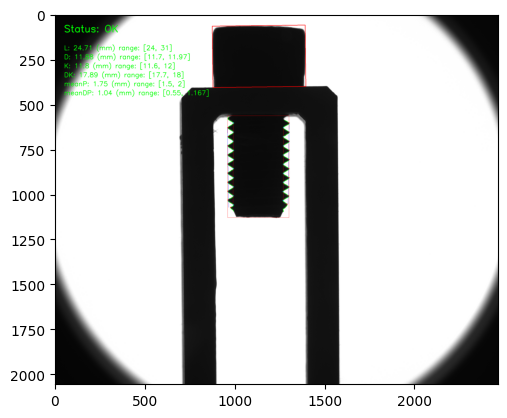

In [20]:
background_fp = "images_w_sizes/template.bmp"
infer_fps = glob("images_w_sizes/M11.85x24.8_DEFECTED/*.bmp")
background_rgb = cv2.cvtColor(cv2.imread(background_fp), cv2.COLOR_BGR2RGB)
measured_values_list = []
for infer_fp in infer_fps:
    infer_rgb = cv2.cvtColor(cv2.imread(infer_fp), cv2.COLOR_BGR2RGB)
    measured_values, viz_im = measure_screw_dimensions(background_rgb, infer_rgb, SCALING_FACTOR, verbose=True)
    inspection_status, viz_im = inspect_screw_dimensions(viz_im, measured_values, REF_VALUES_V1, doff=0.7, scaling_factor=SCALING_FACTOR)
    print(f"\ninspection_status: {inspection_status}")
    measured_values_list.append(measured_values)
    cv2.imwrite(f"viz_{os.path.basename(infer_fp).split('.')[0]}.png", viz_im[:,:,::-1]);
    plt.imshow(viz_im)

In [38]:
stat_df = statistic_on_measured_values(measured_values_list, REF_VALUES_V1, doff=0.7)
stat_df

,##,D,L,K,DK,P,DP
0,Captured 1,11.8800,24.7100,11.8000,17.8500,1.7260,1.0280
1,Captured 2,11.8200,24.7400,11.8000,17.8900,1.7490,1.0360
2,Captured 3,11.9600,24.6000,11.5200,17.8200,1.7480,1.0280
3,Captured 4,11.7800,24.6400,11.7700,17.8600,1.7420,1.0400
4,Captured 5,11.7200,24.6400,11.7300,17.8200,1.7460,1.0390
5,Captured 6,11.8800,24.7100,11.8000,17.8900,1.7480,1.0440
6,Nominal Value [mm],11.9700,30.0000,12.0000,18.0000,1.7500,1.1220
7,Mean [mm],11.8400,24.6733,11.7367,17.8550,1.7432,1.0358
8,Accuracy [mm],0.1300,5.3267,0.2633,0.1450,0.0068,0.0862
9,Repeatability [mm],0.0775,0.0496,0.1001,0.0287,0.0080,0.0060


In [39]:
stat_df.to_csv(f"Statistic_Table.csv", index=False)